# चुनौती: डेटा साइंस के बारे में टेक्स्ट का विश्लेषण

इस उदाहरण में, आइए एक साधारण अभ्यास करें जो पारंपरिक डेटा साइंस प्रक्रिया के सभी चरणों को कवर करता है। आपको कोई कोड लिखने की आवश्यकता नहीं है, आप केवल नीचे दिए गए सेल्स पर क्लिक करके उन्हें निष्पादित कर सकते हैं और परिणाम देख सकते हैं। एक चुनौती के रूप में, आप इस कोड को अलग-अलग डेटा के साथ आज़माने के लिए प्रोत्साहित किए जाते हैं।

## लक्ष्य

इस पाठ में, हमने डेटा साइंस से संबंधित विभिन्न अवधारणाओं पर चर्चा की है। आइए कुछ **टेक्स्ट माइनिंग** करके अधिक संबंधित अवधारणाओं की खोज करने की कोशिश करें। हम डेटा साइंस के बारे में एक टेक्स्ट से शुरुआत करेंगे, उसमें से कीवर्ड निकालेंगे, और फिर परिणाम को विज़ुअलाइज़ करने की कोशिश करेंगे।

टेक्स्ट के रूप में, मैं विकिपीडिया पर डेटा साइंस के पेज का उपयोग करूंगा:


In [62]:
url = 'https://en.wikipedia.org/wiki/Data_science'

## चरण 1: डेटा प्राप्त करना

हर डेटा साइंस प्रक्रिया का पहला चरण डेटा प्राप्त करना होता है। हम इसे करने के लिए `requests` लाइब्रेरी का उपयोग करेंगे:


In [63]:
import requests

text = requests.get(url).content.decode('utf-8')
print(text[:1000])

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Data science - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"1a104647-90de-485a-b88a-1406e889a5d1","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Data_science","wgTitle":"Data science","wgCurRevisionId":1038046078,"wgRevisionId":1038046078,"wgArticleId":35458904,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 maint: others","Articles with short description","Short description matches Wikidata","Use dmy dates from December 2012","Information science","Computer occupations"

## चरण 2: डेटा को रूपांतरित करना

अगला कदम डेटा को उस रूप में बदलना है जो प्रोसेसिंग के लिए उपयुक्त हो। हमारे मामले में, हमने पेज से HTML स्रोत कोड डाउनलोड किया है, और हमें इसे साधारण टेक्स्ट में बदलने की आवश्यकता है।

यह कई तरीकों से किया जा सकता है। हम Python के बिल्ट-इन [HTMLParser](https://docs.python.org/3/library/html.parser.html) ऑब्जेक्ट का सबसे सरल उपयोग करेंगे। हमें `HTMLParser` क्लास को सबक्लास करना होगा और ऐसा कोड परिभाषित करना होगा जो HTML टैग्स के अंदर का सारा टेक्स्ट इकट्ठा करेगा, लेकिन `<script>` और `<style>` टैग्स को छोड़कर।


In [64]:
from html.parser import HTMLParser

class MyHTMLParser(HTMLParser):
    script = False
    res = ""
    def handle_starttag(self, tag, attrs):
        if tag.lower() in ["script","style"]:
            self.script = True
    def handle_endtag(self, tag):
        if tag.lower() in ["script","style"]:
            self.script = False
    def handle_data(self, data):
        if str.strip(data)=="" or self.script:
            return
        self.res += ' '+data.replace('[ edit ]','')

parser = MyHTMLParser()
parser.feed(text)
text = parser.res
print(text[:1000])

 Data science - Wikipedia Data science From Wikipedia, the free encyclopedia Jump to navigation Jump to search Interdisciplinary field of study focused on deriving knowledge and insights from data Not to be confused with  information science . The existence of  Comet NEOWISE  (here depicted as a series of red dots) was discovered by analyzing  astronomical survey  data acquired by a  space telescope , the  Wide-field Infrared Survey Explorer . Part of a series on Machine learning and  data mining Problems Classification Clustering Regression Anomaly detection AutoML Association rules Reinforcement learning Structured prediction Feature engineering Feature learning Online learning Semi-supervised learning Unsupervised learning Learning to rank Grammar induction Supervised learning ( classification  •  regression ) Decision trees Ensembles Bagging Boosting Random forest k -NN Linear regression Naive Bayes Artificial neural networks Logistic regression Perceptron Relevance vector machine 

## चरण 3: जानकारी प्राप्त करना

सबसे महत्वपूर्ण कदम यह है कि हमारे डेटा को ऐसी रूपरेखा में बदलें जिससे हम जानकारी प्राप्त कर सकें। हमारे मामले में, हम टेक्स्ट से कीवर्ड निकालना चाहते हैं और देखना चाहते हैं कि कौन से कीवर्ड अधिक महत्वपूर्ण हैं।

हम कीवर्ड निकालने के लिए [RAKE](https://github.com/aneesha/RAKE) नामक Python लाइब्रेरी का उपयोग करेंगे। सबसे पहले, यदि यह लाइब्रेरी पहले से मौजूद नहीं है, तो इसे इंस्टॉल करें:


In [65]:
import sys
!{sys.executable} -m pip install nlp_rake

C:\winapp\Miniconda3\lib\site-packages\secretstorage\dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
C:\winapp\Miniconda3\lib\site-packages\secretstorage\util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


मुख्य कार्यक्षमता `Rake` ऑब्जेक्ट से उपलब्ध है, जिसे हम कुछ पैरामीटर का उपयोग करके अनुकूलित कर सकते हैं। हमारे मामले में, हम एक कीवर्ड की न्यूनतम लंबाई 5 अक्षरों तक, दस्तावेज़ में एक कीवर्ड की न्यूनतम आवृत्ति 3 तक, और एक कीवर्ड में अधिकतम शब्दों की संख्या 2 तक सेट करेंगे। अन्य मानों के साथ प्रयोग करने और परिणाम देखने के लिए स्वतंत्र महसूस करें।


In [66]:
import nlp_rake
extractor = nlp_rake.Rake(max_words=2,min_freq=3,min_chars=5)
res = extractor.apply(text)
res

[('machine learning', 4.0),
 ('big data', 4.0),
 ('data scientist', 4.0),
 ('21st century', 4.0),
 ('data science', 3.909090909090909),
 ('computer science', 3.909090909090909),
 ('information science', 3.797979797979798),
 ('data analysis', 3.666666666666667),
 ('application domains', 3.6),
 ('science', 1.9090909090909092),
 ('field', 1.25),
 ('statistics', 1.2272727272727273),
 ('classification', 1.2),
 ('techniques', 1.1666666666666667),
 ('datasets', 1.0),
 ('education', 1.0),
 ('archived', 1.0),
 ('original', 1.0),
 ('chikio', 1.0),
 ('forbes', 1.0)]

हमें महत्व के स्तर के साथ एक सूची प्राप्त हुई है। जैसा कि आप देख सकते हैं, सबसे प्रासंगिक विषय, जैसे मशीन लर्निंग और बिग डेटा, सूची में शीर्ष स्थानों पर मौजूद हैं।

## चरण 4: परिणाम को विज़ुअलाइज़ करना

लोग डेटा को सबसे अच्छे तरीके से विज़ुअल फॉर्म में समझ सकते हैं। इसलिए, अक्सर डेटा को विज़ुअलाइज़ करना समझदारी होती है ताकि कुछ अंतर्दृष्टि प्राप्त की जा सके। हम Python में `matplotlib` लाइब्रेरी का उपयोग करके कीवर्ड्स के महत्व के साथ उनकी सरल वितरण को प्लॉट कर सकते हैं:


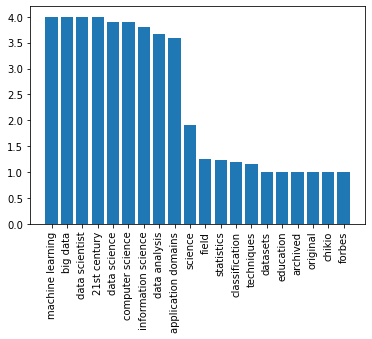

In [67]:
import matplotlib.pyplot as plt

def plot(pair_list):
    k,v = zip(*pair_list)
    plt.bar(range(len(k)),v)
    plt.xticks(range(len(k)),k,rotation='vertical')
    plt.show()

plot(res)

हालांकि, शब्द आवृत्तियों को देखने का एक और बेहतर तरीका है - **वर्ड क्लाउड** का उपयोग करना। हमें अपनी कीवर्ड सूची से वर्ड क्लाउड बनाने के लिए एक और लाइब्रेरी इंस्टॉल करनी होगी।


In [71]:
!{sys.executable} -m pip install wordcloud

`WordCloud` ऑब्जेक्ट मूल पाठ या पहले से गणना की गई शब्दों की सूची उनके आवृत्तियों के साथ लेता है, और एक छवि लौटाता है, जिसे फिर `matplotlib` का उपयोग करके प्रदर्शित किया जा सकता है:


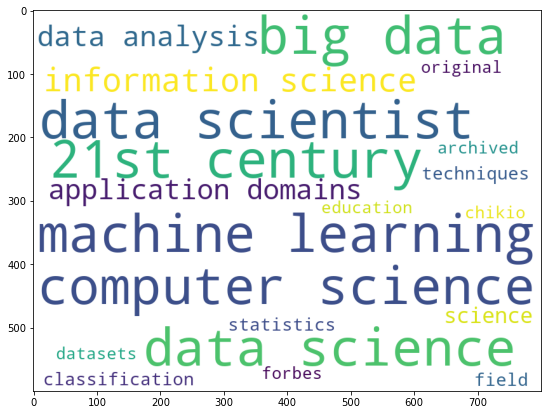

In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white',width=800,height=600)
plt.figure(figsize=(15,7))
plt.imshow(wc.generate_from_frequencies({ k:v for k,v in res }))

हम मूल पाठ को `WordCloud` में भी पास कर सकते हैं - आइए देखें कि क्या हम समान परिणाम प्राप्त कर सकते हैं:


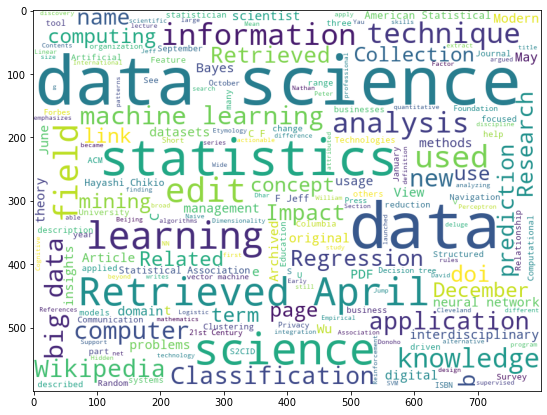

In [70]:
plt.figure(figsize=(15,7))
plt.imshow(wc.generate(text))

In [61]:
wc.generate(text).to_file('images/ds_wordcloud.png')

आप देख सकते हैं कि अब वर्ड क्लाउड अधिक प्रभावशाली दिखता है, लेकिन इसमें बहुत सारा शोर भी है (जैसे कि `Retrieved on` जैसे असंबंधित शब्द)। साथ ही, हमें दो शब्दों वाले कीवर्ड कम मिलते हैं, जैसे *data scientist* या *computer science*। इसका कारण यह है कि RAKE एल्गोरिदम टेक्स्ट से अच्छे कीवर्ड चुनने में बेहतर काम करता है। यह उदाहरण डेटा प्री-प्रोसेसिंग और क्लीनिंग के महत्व को दर्शाता है, क्योंकि अंत में स्पष्ट तस्वीर हमें बेहतर निर्णय लेने में मदद करेगी।

इस अभ्यास में हमने Wikipedia टेक्स्ट से कुछ अर्थ निकालने की एक सरल प्रक्रिया को देखा, कीवर्ड और वर्ड क्लाउड के रूप में। यह उदाहरण काफी सरल है, लेकिन यह उन सभी सामान्य चरणों को अच्छी तरह से प्रदर्शित करता है, जिन्हें एक डेटा वैज्ञानिक डेटा के साथ काम करते समय अपनाता है, डेटा अधिग्रहण से लेकर विज़ुअलाइज़ेशन तक।

हमारे कोर्स में हम इन सभी चरणों पर विस्तार से चर्चा करेंगे।



---

**अस्वीकरण**:  
यह दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) का उपयोग करके अनुवादित किया गया है। जबकि हम सटीकता सुनिश्चित करने का प्रयास करते हैं, कृपया ध्यान दें कि स्वचालित अनुवाद में त्रुटियां या अशुद्धियां हो सकती हैं। मूल भाषा में उपलब्ध मूल दस्तावेज़ को प्रामाणिक स्रोत माना जाना चाहिए। महत्वपूर्ण जानकारी के लिए, पेशेवर मानव अनुवाद की सिफारिश की जाती है। इस अनुवाद के उपयोग से उत्पन्न किसी भी गलतफहमी या गलत व्याख्या के लिए हम जिम्मेदार नहीं हैं।
